<a href="https://colab.research.google.com/github/PiotMik/NumericalMethodsForSDEs/blob/main/Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Optional
sns.set()
plt.rcParams['figure.figsize'] = (10, 5)

## Poisson process simulation

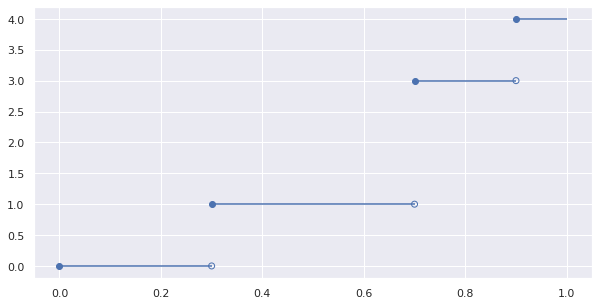

In [63]:
def plot_step(jump_moments, jump_sizes, 
              horizon: Optional[float]=None, is_cadlag = False):
  """
  Plot a step process

  Parameters
  --------
  jump_moments: iterable
    Iterable of floats, moments of jumps
  jump_sizes: iterable
    Iterable of integers, size of jumps
  horizon: Optional[float]
    Maximal xaxis value
  is_cadlag: bool
    Whether to use a cadlag markers
  """
  levels = np.array(jump_sizes).cumsum()
  jump_moments = np.array(jump_moments)

  if jump_moments[0] != 0.0:
    levels = np.concatenate([np.array([0]), levels])
    jump_moments = np.concatenate([np.array([0]), jump_moments])
  if horizon is not None and jump_moments[-1] != horizon:
    levels = np.concatenate([levels, np.array([levels[-1]])])
    jump_moments = np.concatenate([jump_moments, np.array([horizon])])
  
  df = pd.DataFrame.from_dict({'t': jump_moments,
                               'Nt': levels})
  if not is_cadlag:  
    df.set_index('t', inplace=True)
    df.plot(drawstyle="steps-post")
  else:
    fig, ax = plt.subplots()
    for t_left, t_right, level in zip(df['t'][:-1], df['t'][1:], levels):
        ax.hlines(y=level, xmin=t_left, xmax=t_right, color='b')
    ax.scatter(x = df.t[:-1], y = df.Nt[:-1], color='b')
    ax.scatter(x = df.t[1:-1], y = df.Nt[:-2], facecolors='none', edgecolors='b')
  return df  

t = [0.3, 0.7, 0.9]
jump_sizes = [1, 2, 1]
_ = plot_step(jump_moments = t, jump_sizes = jump_sizes,
              horizon=1, is_cadlag=True)

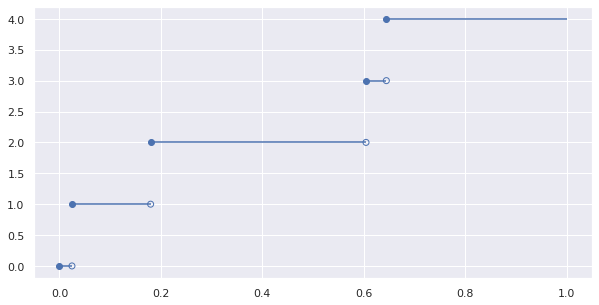

In [115]:
def generate_poisson_process_v1(T:float, lam: float):
  """
  Generate Poisson Process by:
    1) simulating waiting times for the next jump
    2) performing a jump of size 1
  
  Parameters
  --------
  T: float
    Time horizon for the simulation
  lam: float
    Intensity of the Poisson process
  
  Returns
  --------
  xs, dys
    Jump moments, and jump sizes (always a 1)
  """
  t = np.random.exponential(scale=1./lam)
  dys = [0.0]
  xs = [0.0]
  while t < T:
    xs.append(t)
    dys.append(1)
    t += np.random.exponential(scale=1./lam)
  
  xs, dys = np.array(xs), np.array(dys)
  return xs, dys

x, dy = generate_poisson_process_v1(1, 3)
_ = plot_step(x, dy, horizon=1, is_cadlag=True)

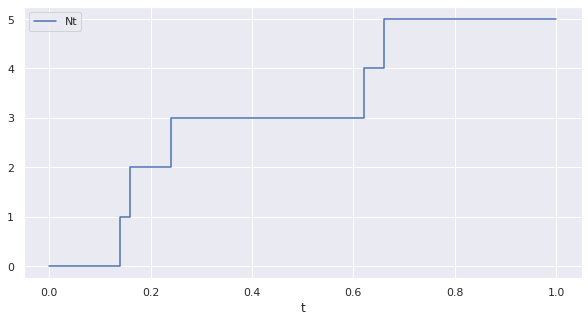

In [117]:
def generate_poisson_process_v2(T:float, lam: float, N: int):
  """
  Generate Poisson Process by:
    1) time axis discretization
    2) simulating number of jumps for each time interval
    3) performing a jump of that size (no separate jumps inside that interval)
  
  Parameters
  --------
  T: float
    Time horizon for the simulation
  lam: float
    Intensity of the Poisson process
  N: int
    Number of discretization steps
  
  Returns
  --------
  xs, dys
    Jump moments, and jump sizes
  """
  dt = T/N
  t = dt
  dys = [0.0]
  xs = [0.0]
  while t < T:
    n_jumps = np.random.poisson(lam = lam*dt)
    xs.append(t)
    dys.append(n_jumps)
    t += dt
  xs, dys = np.array(xs), np.array(dys)
  return xs, dys

x, dy = generate_poisson_process_v2(T = 1, lam = 3, N = 50)
_ = plot_step(x, dy, horizon=1, is_cadlag=False)

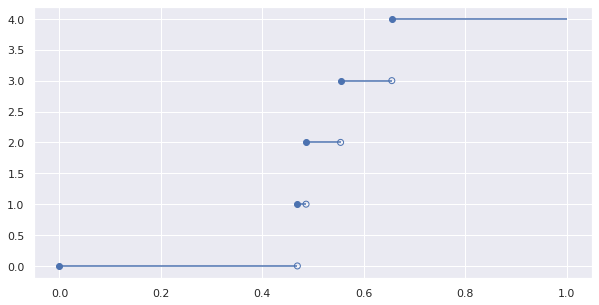

In [104]:
def generate_poisson_process_v3(T: float, lam: float, N: int):
  """
  Generate Poisson Process by
    1) time axis discretization.
    2) simulating number of jumps for each time interval
    3) simulating that number of jump moments inside the interval
  
  Parameters
  --------
  T: float
    Time horizon for the simulation
  lam: float
    Intensity of the Poisson process
  N: int
    Number of discretization steps
  
  Returns
  --------
  xs, dys
    Jump moments, and jump sizes (here, an array of ones)
  """
  dt = T/N
  t_min = 0.0
  t_max = dt
  dys = [0.0]
  xs = [0.0]
  while t_max + dt < T:
    # iterating over [t_min, t_max] intervals
    t_max = min(t_max, T)
    n_jumps = np.random.poisson(lam = lam*(t_max - t_min))
    if n_jumps == 0:
      t_min += dt
      t_max += dt
      continue
    else:
      jump_moments = sorted(np.random.uniform(low = t_min, high=t_max, size = n_jumps))
      xs += jump_moments
      dys += [1]*n_jumps
    t_min += dt
    t_max += dt
  
  xs, dys = np.array(xs), np.array(dys)
  return xs, dys

x, dy = generate_poisson_process_v3(T = 1, lam = 3, N = 50)
_ = plot_step(x, dy, horizon=1, is_cadlag=True)

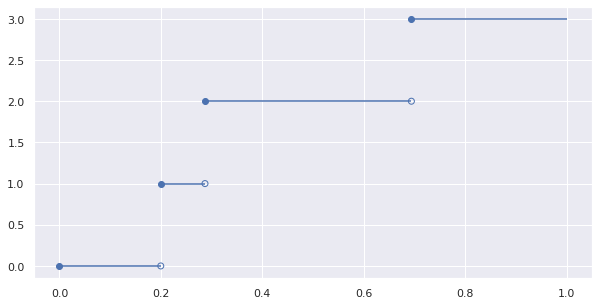

In [118]:
def generate_poisson_process_v4(T: float, lam: float):
  """
  Generate Poisson Process by
    1) simulating number of jumps for the whole process
    2) simulating their occurence times

  Parameters
  --------
  T: float
    Time horizon for the simulation
  lam: float
    Intensity of the Poisson process
  
  Returns
  --------
  xs, dys
    Jump moments, and jump sizes (here, an array of ones)
  """
  n_jumps = np.random.poisson(T*lam)
  jump_moments = np.random.uniform(low = 0.0, high = T, size=n_jumps)

  xs = [0] + sorted(jump_moments)
  dys = [0] + [1]*n_jumps

  xs, dys = np.array(xs), np.array(dys) 
  return xs, dys
x, dy = generate_poisson_process_v4(T = 1, lam = 3)
_ = plot_step(x, dy, horizon=1, is_cadlag=True)